<a href="https://colab.research.google.com/github/jacky5649/1221/blob/main/WiDS_Datathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This ensures that any edits to libraries you make are reloaded here automatically,
# and also that any charts or images displayed are shown in this notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# Import libraries
from fastai import *
from fastai.vision import *
from fastai.callbacks import CSVLogger, SaveModelCallback
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# see the folders available
import os
os.listdir(os.getcwd())

['.config', 'sample_data']

In [ ]:
# create a directory to download the competition data to and change the working
# directory to that location
os.mkdir('data')
%cd data/
os.getcwd()

/content/data


'/content/data'

In [ ]:
# Get the data from dropbox link
!wget https://www.dropbox.com/s/6kltw0kqynlijxv/widsdatathon2019.zip

In [ ]:
# The downloaded competition data is zipped, let us unzip it
!unzip widsdatathon2019.zip

Archive:  widsdatathon2019.zip
  inflating: train_images.zip        
  inflating: traininglabels.csv      
  inflating: SampleSubmission.csv    
  inflating: leaderboard_holdout_data.zip  
  inflating: leaderboard_test_data.zip  


In [ ]:
# The training and testing data have already been seperated, Unzip them as well
!unzip train_images.zip
!unzip leaderboard_holdout_data.zip
!unzip leaderboard_test_data.zip

In [ ]:
# Change the working directory to the previous one ['data']
%cd ../
os.listdir(os.getcwd())

/content


['.config', 'data', 'sample_data']

## Looking at the data

The first thing to do when we approach a problem is to take a look at the available data. We'll need to understand the problem and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels were stored in a csv file.

In [ ]:
# Set the Path to the data directory and list out the path names
path = Path('data/')
path.ls()

[PosixPath('data/leaderboard_test_data.zip'),
 PosixPath('data/leaderboard_test_data'),
 PosixPath('data/train_images.zip'),
 PosixPath('data/leaderboard_holdout_data'),
 PosixPath('data/leaderboard_holdout_data.zip'),
 PosixPath('data/SampleSubmission.csv'),
 PosixPath('data/train_images'),
 PosixPath('data/traininglabels.csv'),
 PosixPath('data/widsdatathon2019.zip')]

In [ ]:
# Assign the test, train and leaderboard_test dataset to variables we'll call later
train = Path('data/train_images')
test = Path('data/leaderboard_test_data')
lb_test = Path('data/leaderboard_holdout_data')
train.ls()[:5]

[PosixPath('data/train_images/img_022462017.jpg'),
 PosixPath('data/train_images/img_026632017.jpg'),
 PosixPath('data/train_images/img_037952017.jpg'),
 PosixPath('data/train_images/img_038612017.jpg'),
 PosixPath('data/train_images/img_046592018.jpg')]

In [ ]:
# Overview of the labels of the training data;
df = pd.read_csv('data/traininglabels.csv')
df.head()

,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000


In [ ]:
# Our data has no missing entries, this is known as a clean dataset.
# We do not have to worry about cleaning it up
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15244 entries, 0 to 15243
Data columns (total 3 columns):
image_id       15244 non-null object
has_oilpalm    15244 non-null int64
score          15244 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 357.4+ KB


### Let's look at the data a little

In [ ]:
# Number of images in our training set without oil palm plantations in them
df[df.has_oilpalm == 0].count()

image_id       14302
has_oilpalm    14302
score          14302
dtype: int64

In [ ]:
# Number of images in our training set with oil palm plantations in them
df[df.has_oilpalm == 1].count()

image_id       942
has_oilpalm    942
score          942
dtype: int64

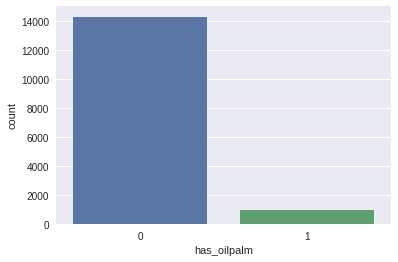

In [ ]:
sns.countplot(df.has_oilpalm);

### Combine the test and leaderboard holdout test data
We are going to combine both of them cause we are required to submit predictions for both sets to the competition.

In [ ]:
test_imgs = [i for i in test.iterdir()]
hold_imgs = [i for i in lb_test.iterdir()]
combined_test = test_imgs + hold_imgs
len(combined_test)

6534

In [ ]:
src = (ImageList.from_df(df, path, folder='train_images')
      .random_split_by_pct(0.2, seed=14)
      .label_from_df('has_oilpalm')
      .add_test(combined_test))

In [ ]:
data = (src.transform(get_transforms(flip_vert=True), size=164)
           .databunch()
           .normalize(imagenet_stats))

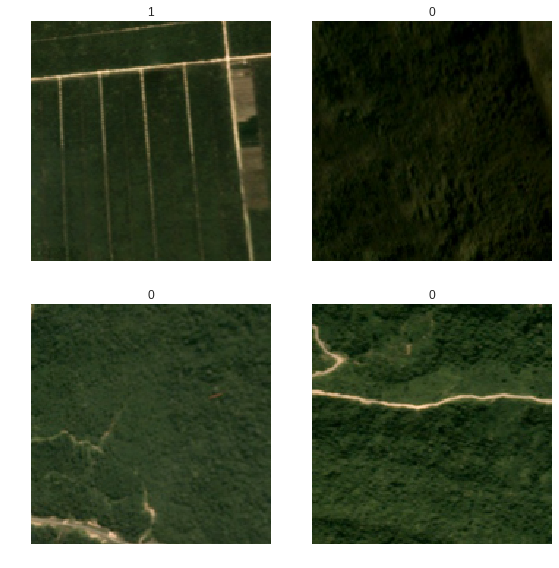

In [ ]:
data.show_batch(2)

In [ ]:
data

ImageDataBunch;

Train: LabelList (12196 items)
x: ImageList
Image (3, 164, 164),Image (3, 164, 164),Image (3, 164, 164),Image (3, 164, 164),Image (3, 164, 164)
y: CategoryList
0,0,0,0,0
Path: data;

Valid: LabelList (3048 items)
x: ImageList
Image (3, 164, 164),Image (3, 164, 164),Image (3, 164, 164),Image (3, 164, 164),Image (3, 164, 164)
y: CategoryList
0,0,0,0,0
Path: data;

Test: LabelList (6534 items)
x: ImageList
Image (3, 164, 164),Image (3, 164, 164),Image (3, 164, 164),Image (3, 164, 164),Image (3, 164, 164)
y: EmptyLabelList
,,,,
Path: data

In [ ]:
learn = create_cnn(data, models.resnet50, metrics=[accuracy, error_rate],
                  callback_fns=[ShowGraph, SaveModelCallback])
#learn.model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


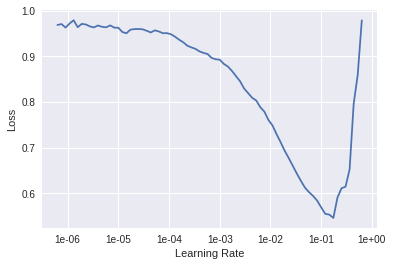

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,0.089062,0.038298,02:30
1,0.057118,0.022132,02:25
2,0.047621,0.019228,02:25
3,0.031032,0.019050,02:25
4,0.024849,0.016692,02:25


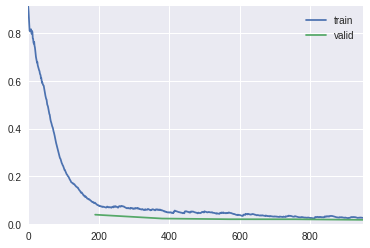

Better model found at epoch 0 with val_loss value: 0.0382978729903698.
Better model found at epoch 1 with val_loss value: 0.022132480517029762.
Better model found at epoch 2 with val_loss value: 0.019228165969252586.
Better model found at epoch 3 with val_loss value: 0.019049718976020813.
Better model found at epoch 4 with val_loss value: 0.016692087054252625.


In [ ]:
learn.fit_one_cycle(5, slice(1e-2))

In [ ]:
from sklearn.metrics import roc_auc_score
def auc_score(y_score,y_true):
    return torch.tensor(roc_auc_score(y_true,y_score[:,1]))
probs,val_labels = learn.get_preds(ds_type=DatasetType.Valid)
print('Accuracy',accuracy(probs,val_labels)),
print('Error Rate', error_rate(probs, val_labels))
print('AUC', auc_score(probs,val_labels))

Accuracy tensor(0.9944)
Error Rate tensor(0.0056)
AUC tensor(0.9982)


In [ ]:
learn.save('resnet50-stg1')

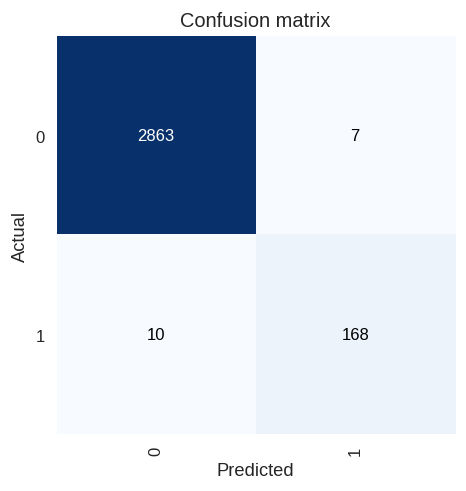

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(dpi=120)

Our model is working as we expect it to, we will *unfreeze* our model and train for more cycles.

In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


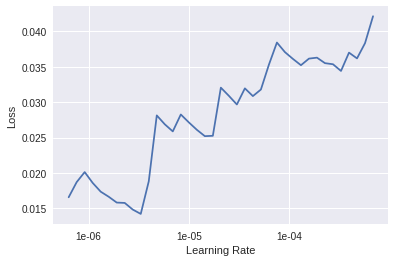

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,0.022730,0.016845,03:12
1,0.025994,0.017177,03:12
2,0.020752,0.017535,03:11
3,0.025211,0.019888,03:12
4,0.017164,0.016891,03:12
5,0.017434,0.018433,03:12
6,0.016608,0.016302,03:12


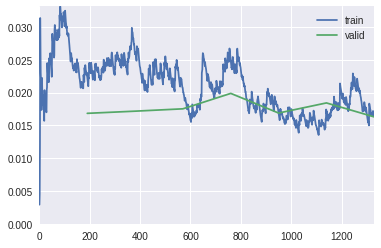

Better model found at epoch 0 with val_loss value: 0.016845498234033585.
Better model found at epoch 6 with val_loss value: 0.016301672905683517.


In [ ]:
learn.fit_one_cycle(7, max_lr=slice(1e-6,1e-4))

In [ ]:
learn.save('resnet50-stg2')

In [ ]:
probs,val_labels = learn.get_preds(ds_type=DatasetType.Valid)
print('Accuracy',accuracy(probs,val_labels)),
print('Error Rate', error_rate(probs, val_labels))
print('AUC', auc_score(probs,val_labels))

Accuracy tensor(0.9948)
Error Rate tensor(0.0052)
AUC tensor(0.9987)


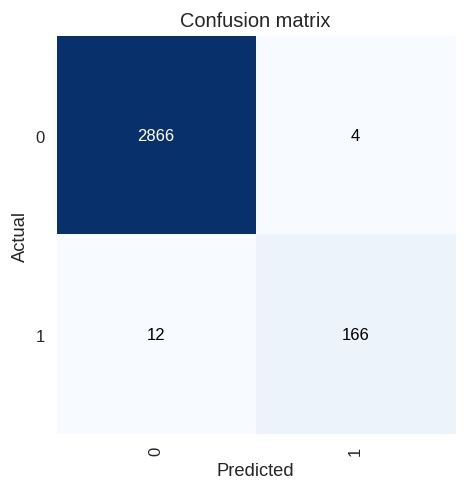

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(dpi=120)

We'll perform some more image transformations on our data. This should improve our model. [Read up on this]

In [ ]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
data = (src.transform(tfms, size=200)
        .databunch().normalize(imagenet_stats))

learn.data = data

data.train_ds[0][0].shape

torch.Size([3, 200, 200])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


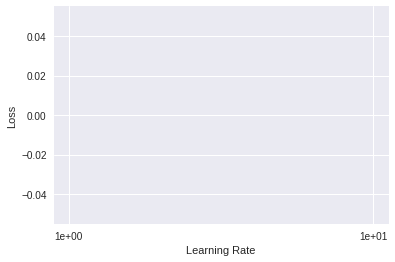

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,0.016343,0.018521,03:22
1,0.015139,0.017912,03:15
2,0.016068,0.017795,03:15
3,0.011350,0.016985,03:16
4,0.016060,0.018044,03:15


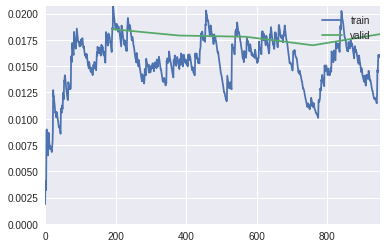

Better model found at epoch 0 with val_loss value: 0.01852061226963997.
Better model found at epoch 1 with val_loss value: 0.01791241206228733.
Better model found at epoch 2 with val_loss value: 0.017794594168663025.
Better model found at epoch 3 with val_loss value: 0.01698542758822441.


In [ ]:
learn.fit_one_cycle(5, 1e-6)

In [ ]:
learn.save('resnet50-stg3')

In [ ]:
probs,val_labels = learn.get_preds(ds_type=DatasetType.Valid)
print('Accuracy',accuracy(probs,val_labels)),
print('Error Rate', error_rate(probs, val_labels))
print('AUC', auc_score(probs,val_labels))

Accuracy tensor(0.9938)
Error Rate tensor(0.0062)
AUC tensor(0.9991)


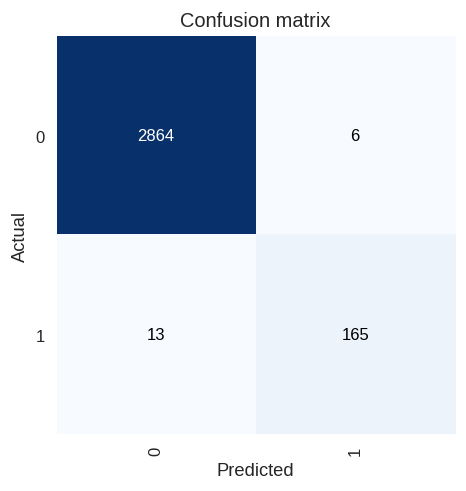

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(dpi=120)

In [ ]:
learn.freeze()

In [ ]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data

data.train_ds[0][0].shape

torch.Size([3, 256, 256])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


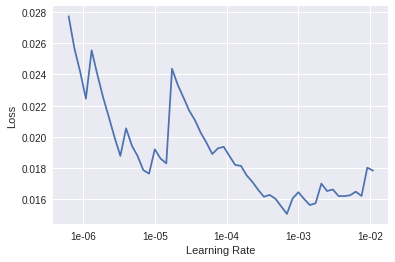

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,0.013292,0.019061,04:24
1,0.014643,0.018970,04:23
2,0.014409,0.016812,04:23
3,0.014867,0.018523,04:23
4,0.016856,0.017836,04:23


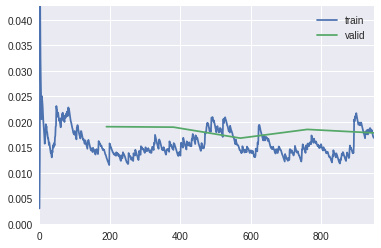

Better model found at epoch 0 with val_loss value: 0.019060717895627022.
Better model found at epoch 1 with val_loss value: 0.01897037960588932.
Better model found at epoch 2 with val_loss value: 0.01681198924779892.


In [ ]:
learn.fit_one_cycle(5, slice(1e-4))

In [ ]:
learn.save('resnet50-stg4')

In [ ]:
probs,val_labels = learn.get_preds(ds_type=DatasetType.Valid)
print('Accuracy',accuracy(probs,val_labels)),
print('Error Rate', error_rate(probs, val_labels))
print('AUC', auc_score(probs,val_labels))

Accuracy tensor(0.9944)
Error Rate tensor(0.0056)
AUC tensor(0.9989)


In [ ]:
p,t = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
p = to_np(p);
p.shape

(6534, 2)

In [ ]:
ids = np.array([f.name for f in (combined_test)]);
ids.shape

(6534,)

In [ ]:
sample_sub = Path('data/SampleSubmission.csv')
df_sample = pd.read_csv(sample_sub)

In [ ]:
sub = pd.DataFrame(np.stack([ids, p[:,1]], axis=1), columns=df_sample.columns)

In [ ]:
sub.to_csv(path/'wids-notebook.csv', index=False)